In [1]:
import os 
import nibabel as nib 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from MyUnet import UNet

from tqdm import tqdm 
from typing import Dict, List, Tuple 
from pathlib import Path

In [2]:
# Device agnostic code
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [3]:
# Function to plot inputs

def plot_inputs(inputs):

    plt.style.use('ggplot')
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'
    plt.figure(figsize=(16, 5))

    plt.subplot(1,4,1)
    plt.imshow(inputs[1], cmap='magma')
    plt.title('T1')
    plt.axis(False)
    
    plt.subplot(1,4,2)
    plt.imshow(inputs[2], cmap='magma')
    plt.title('T1-Weighted')
    plt.axis(False)
    
    plt.subplot(1,4,3)
    plt.imshow(inputs[3], cmap='magma')
    plt.title('T2')
    plt.axis(False)
    
    plt.subplot(1,4,4)
    plt.imshow(inputs[0], cmap='magma')
    plt.title('T2 FLAIR')
    plt.axis(False)
    
    plt.suptitle('Input Images', fontsize=20)
    plt.tight_layout()
    plt.show()

In [4]:
# Function to plot outputs

def plot_targets(targets, title):

    plt.style.use('ggplot')
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1,3,1)
    plt.imshow(torch.stack((targets[0], torch.zeros_like(targets[0]), torch.zeros_like(targets[0])), dim=0).permute(1,2,0))
    plt.title('Necrotic')
    plt.axis(False)
    
    plt.subplot(1,3,2)
    plt.imshow(torch.stack((torch.zeros_like(targets[1]), targets[1], torch.zeros_like(targets[1])), dim=0).permute(1,2,0))
    plt.title('Edema')
    plt.axis(False)
    
    plt.subplot(1,3,3)
    plt.imshow(torch.stack((torch.zeros_like(targets[2]), torch.zeros_like(targets[2]), targets[2]), dim=0).permute(1,2,0))
    plt.title('Tumor')
    plt.axis(False)
    
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [5]:
# Creating custom dataset class

class BraTSData(Dataset):
    
    def __init__(self, root_dir, input_transform=None, target_transform=None):
        
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.inputs = []
        self.outputs = []
        
        names = ['flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz']
        mask_name = 'seg.nii.gz'
        
        for patient in os.listdir(root_dir):
            input_names = []
            for i in names:
                input_names.append(os.path.join(root_dir, patient, i))
            self.inputs.append(input_names)
            self.outputs.append(os.path.join(root_dir, patient, mask_name))

    def __len__(self):
        return len(self.outputs)*155 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        patient_idx = idx//155
        slice_idx = idx%155
        
        input_img = []
        for i in self.inputs[patient_idx]:
            img = nib.load(i)
            img = img.get_fdata()[:,:,slice_idx]
            if img.max() - img.min() == 0:
                img = np.zeros_like(img).astype(np.uint8)
            else:
                img = ((img - img.min()) / (img.max()-img.min()) * 255).astype(np.uint8)
            input_img.append(img)
        input_img = np.array(input_img)
        input_img = np.transpose(input_img, (1,2,0))
        input_img = Image.fromarray(input_img)
        if self.input_transform:
            input_img = self.input_transform(input_img)
        
        img = nib.load(self.outputs[patient_idx])
        img = img.get_fdata()[:,:,slice_idx]
        necrotic = torch.tensor((img == 1), dtype=torch.float32)
        edema = torch.tensor((img == 2), dtype=torch.float32)
        tumor = torch.tensor((img == 4), dtype=torch.float32)
        
        if self.target_transform:
            necrotic = self.target_transform(necrotic)
            edema = self.target_transform(edema)
            tumor = self.target_transform(tumor)
        target_img = torch.stack([necrotic, edema, tumor], axis=0)
        
        data = {'Input':input_img, 'Target':target_img}
        return data

In [6]:
# Creating train and test datasets 

train_dir = 'Processed Data/Train'
test_dir = 'Processed Data/Test'

input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*4, std=[0.5]*4)
])

train_data = BraTSData(root_dir=train_dir, input_transform=input_transform, target_transform=None)
test_data = BraTSData(root_dir=test_dir, input_transform=input_transform, target_transform=None)

len(train_data), len(test_data)

(174375, 19530)

Data Index : 68429


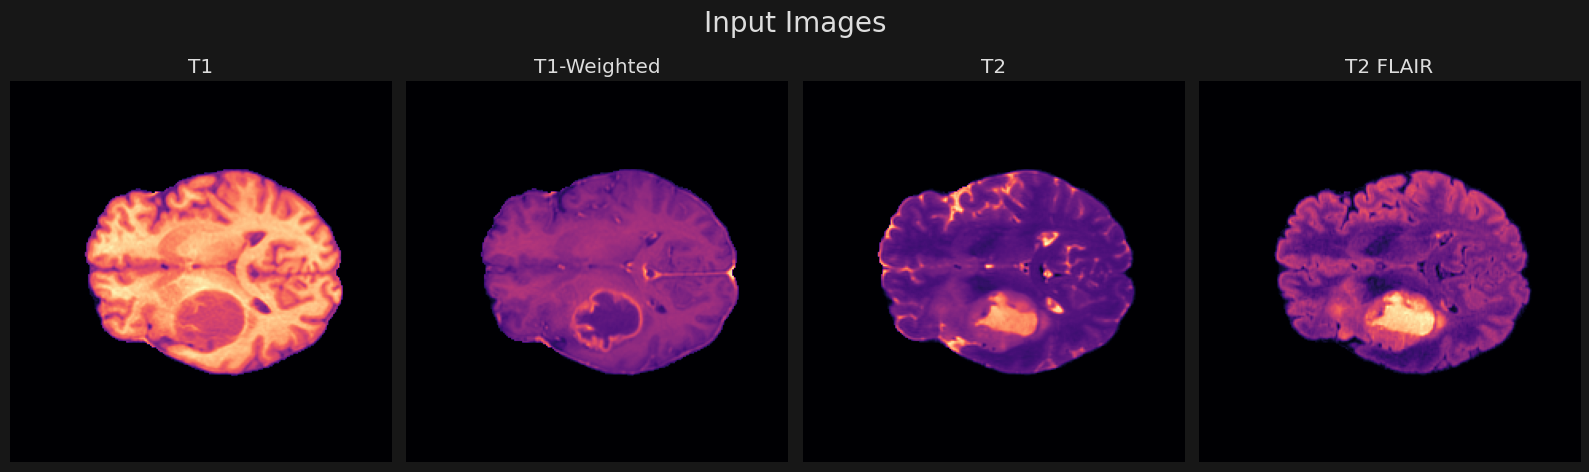

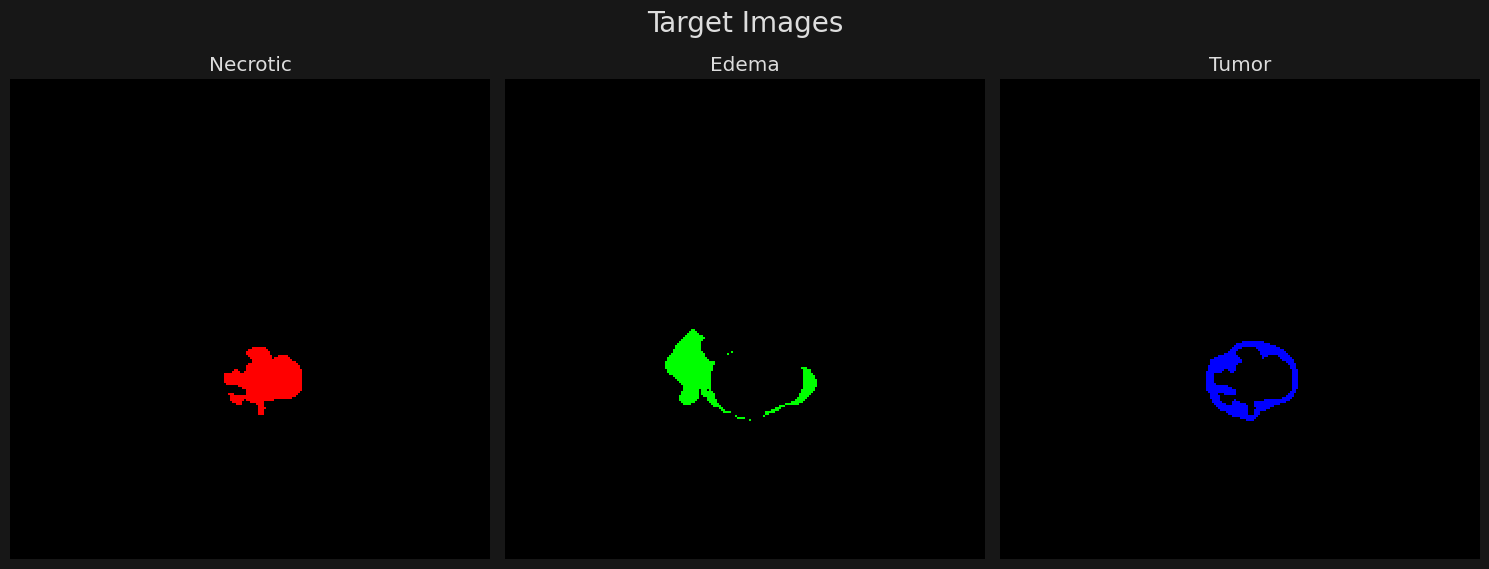

In [7]:
# Plotting a random sample from the train data 

random_idx = torch.randint(0, len(train_data), (1,)).item()
sample_input = train_data[random_idx]['Input']
sample_target = train_data[random_idx]['Target']

print(f'Data Index : {random_idx}')
plot_inputs(inputs=sample_input)
plot_targets(targets=sample_target, title='Target Images') 

In [8]:
# model = UNet(4, 3).to(device)
# rnd = torch.randn(3, 4, 240, 240).to(device)
# with torch.cuda.amp.autocast():
#     ylogit = model(rnd)
# ylogit.unique()

In [9]:
# Creating dataloaders 

BATCH_SIZE = 5
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

(34875, 3906)

In [10]:
# Visualising dataloader loaded images 

batch = next(iter(train_dataloader))
batch['Input'].size(), batch['Target'].size()

(torch.Size([5, 4, 240, 240]), torch.Size([5, 3, 240, 240]))

In [11]:
# Functions to train and test batches 

def train_batch(model:torch.nn.Module,
                batch:tuple,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                scaler:torch.cuda.amp.GradScaler,
                device:torch.device) -> Tuple[float]:
    
    model.train()
    xtrain, ytrain = batch['Input'].to(device), batch['Target'].to(device)
    
    with torch.cuda.amp.autocast():
        ylogit = model(xtrain)
        loss = loss_fn(ylogit, ytrain)
        
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    del xtrain, ytrain, ylogit
    
    return loss.item()


def test_batch(model:torch.nn.Module,
                batch:tuple,
                loss_fn:torch.nn.Module,
                device:torch.device) -> Tuple[float]:
    
    model.eval()
    xtest, ytest = batch['Input'].to(device), batch['Target'].to(device)
    
    with torch.inference_mode():
        with torch.cuda.amp.autocast():
            ylogit = model(xtest)
            loss = loss_fn(ylogit, ytest)
    
    del xtest, ytest, ylogit
    
    return loss.item()


def train_model(model:torch.nn.Module,
                train_dataloader:torch.utils.data.DataLoader,
                test_dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                scaler:torch.cuda.amp.GradScaler,
                epochs:int,
                device:torch.device,
                random_seed:int=None,
                save_path:str=None) -> Dict[str, List[float]] :
    
    if random_seed:
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        
    results = {
        'Train Loss' : [],
        'Test Loss' : []
    }
    
    for epoch in range(1, epochs+1):
        
        # Training step
        train_loss = 0
        with tqdm(enumerate(train_dataloader), total=len(train_dataloader)) as t:
            for i, batch in t:
                batch_loss = train_batch(model=model, batch=batch, loss_fn=loss_fn, optimizer=optimizer, scaler=scaler, device=device)
                train_loss += batch_loss
                t.set_description(f'Epoch [{epoch}/{epochs}] (Training)')
                t.set_postfix({
                    'Batch Loss' : batch_loss,
                    'Train Loss' : train_loss/(i+1)
                })
                
                if save_path:
                    torch.save(obj=model.state_dict(), f=save_path)
                
        # Testing step
        test_loss = 0
        with tqdm(enumerate(test_dataloader), total=len(test_dataloader)) as t:
            for i, batch in t:
                batch_loss = test_batch(model=model, batch=batch, loss_fn=loss_fn, device=device)
                test_loss += batch_loss
                t.set_description(f'Epoch [{epoch}/{epochs}] (Testing)')
                t.set_postfix({
                    'Batch Loss' : batch_loss,
                    'Test Loss' : test_loss/(i+1)
                })
                
        print('---------------------------------------------------------------------------------------------------------------------------------------------------------')
        
        train_loss = train_loss/len(train_dataloader)
        test_loss = test_loss/len(test_dataloader)
        
        results['Train Loss'].append(train_loss)
        results['Test Loss'].append(test_loss)
            
    return results

In [12]:
# Defining the model, loss function, optimizer and GradScaler

class BCELossWithLogits(nn.Module):
    def __init__(self):
        super(BCELossWithLogits, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        return self.bce_loss(inputs, targets)

MODEL_SAVE_PATH = 'Models/final_train.pth'
MODEL_SAVE_PATH_2 = 'Models/final_train_2.pth'
model = UNet(in_channels=4, out_channels=3).to(device)
loss_fn = BCELossWithLogits()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

# Loading the model if it exists
model_file = Path(MODEL_SAVE_PATH_2)
if model_file.is_file():
    model.load_state_dict(torch.load(f=MODEL_SAVE_PATH_2))
    print("A model aleady exists... Loading that model and training it for the specified epochs")
else:
    print("A model does not exist in the specified path... Creating the model and training it for the specified epochs")

A model aleady exists... Loading that model and training it for the specified epochs


In [13]:
# Training the model 
# Till now : 0 Epochs

NUM_EPOCHS = 1

train_model(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, scaler=scaler, epochs=NUM_EPOCHS, device=device, save_path=MODEL_SAVE_PATH)

Epoch [1/1] (Testing):  20%|██        | 796/3906 [18:43<1:17:06,  1.49s/it, Batch Loss=0.00187, Test Loss=0.00302] 

In [13]:
# Saving model 
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH_2)